In [ ]:
from pathlib import Path

repo_url  = 'https://github.com/rtqichen/torchdiffeq'
project_path        = Path('/').absolute() / 'content'
neuralode_repo_path = project_path / 'NeuralODE'

# Create project folder if inexistant
if not project_path.is_dir():
    %mkdir "{project_path}"
%cd "{project_path}"

# Download repository
!git config --global user.name "ucabres"
!git config --global user.email "ucabres@ucl.ac.uk"
if neuralode_repo_path.is_dir():
    !git -C "{neuralode_repo_path}" fetch origin
    !git -C "{neuralode_repo_path}" checkout origin/main -- *.py
else:
    print("Install repository")
    !git clone {repo_url}

/content
Install repository
Cloning into 'torchdiffeq'...
remote: Enumerating objects: 1138, done.
remote: Counting objects: 100% (434/434), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 1138 (delta 256), reused 400 (delta 240), pack-reused 704
Receiving objects: 100% (1138/1138), 8.29 MiB | 33.29 MiB/s, done.
Resolving deltas: 100% (682/682), done.


In [ ]:
%cd torchdiffeq/

/content/torchdiffeq


In [ ]:
import os
import argparse
import logging
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, MultiStepLR

import sys
sys.argv = ['']

parser = argparse.ArgumentParser()
parser.add_argument('--ode', action='store_true', default=True,
                    help='Train NeutralODE model or Resnet model')
parser.add_argument('--tol', type=float, default=1e-3)
parser.add_argument('--adjoint', type=eval, default=False, choices=[True, False])
parser.add_argument('--downsampling-method', type=str, default='conv', choices=['conv', 'res'])
parser.add_argument('--nepochs', type=int, default=160)
parser.add_argument('--data_aug', type=eval, default=True, choices=[True, False])
parser.add_argument('--lr', type=float, default=0.1)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--test_batch_size', type=int, default=128)
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')

parser.add_argument('--save-model', action='store_true', default=False,
                    help='For Saving the current Model')
parser.add_argument('--debug', action='store_true')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--gpu', type=int, default=0)
args = parser.parse_args()

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint


class ODEfunc(nn.Module):
    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.ff = nn.Linear(dim, dim)
        self.relu = nn.ReLU(inplace=True)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.ff(x)
        out = self.relu(out)
        return out


class ODEBlock(nn.Module):

    def __init__(self, odefunc, T=1):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, T]).float()
        self.step_size = T*1.0/100

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        # out = odeint(self.odefunc, x, self.integration_time, method='euler', rtol=args.tol, atol=args.tol, options={'step_size':self.step_size})
        out = odeint(self.odefunc, x, self.integration_time, method='dopri5', rtol=args.tol, atol=args.tol)
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value


class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

class Net(nn.Module):
    def __init__(self, ode=True):
        super(Net, self).__init__()
        # downsampling_layers = [
        # ]
        # feature_layers = [
        #     Flatten(), 
        #     ODEBlock(ODEfunc(3*32*32), T=1)
        # ]
        # fc_layers = [
        #     Flatten(), 
        #     nn.Linear(3*32*32, 10)
        # ]
        downsampling_layers = [
            nn.Conv2d(3, 3, 4, 2, 1),
            nn.ReLU(inplace=True),
        ]
        feature_layers = [
            Flatten(), 
            ODEBlock(ODEfunc(3*16*16), T=1)
        ]
        fc_layers = [
            Flatten(), 
            nn.Linear(3*16*16, 10)
        ]
        self.model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers)

    def forward(self, x):
        x = self.model(x)
        out = F.log_softmax(x, dim=1)
        return out


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
use_cuda = True
torch.manual_seed(args.seed)


args.epochs = 20


device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_whole = datasets.CIFAR10('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]))
test_whole = datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]))

train_dataset = torch.utils.data.Subset(train_whole, range(512))
test_dataset = torch.utils.data.Subset(test_whole, range(128))

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

model = Net(args.ode).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)
    scheduler.step()

if args.save_model:
    torch.save(model.state_dict(), "mnist_cnn.pt")

Files already downloaded and verified
Train Epoch: 1 [0/512 (0%)]	Loss: 2.302788

Test set: Average loss: 2.2981, Accuracy: 12/128 (9%)

Train Epoch: 2 [0/512 (0%)]	Loss: 2.279429

Test set: Average loss: 2.3034, Accuracy: 13/128 (10%)

Train Epoch: 3 [0/512 (0%)]	Loss: 2.249310

Test set: Average loss: 2.2492, Accuracy: 22/128 (17%)

Train Epoch: 4 [0/512 (0%)]	Loss: 2.224255

Test set: Average loss: 2.1468, Accuracy: 31/128 (24%)

Train Epoch: 5 [0/512 (0%)]	Loss: 2.131997

Test set: Average loss: 2.1081, Accuracy: 31/128 (24%)

Train Epoch: 6 [0/512 (0%)]	Loss: 2.058265

Test set: Average loss: 2.0563, Accuracy: 31/128 (24%)

Train Epoch: 7 [0/512 (0%)]	Loss: 1.895233

Test set: Average loss: 2.0196, Accuracy: 38/128 (30%)

Train Epoch: 8 [0/512 (0%)]	Loss: 1.845958

Test set: Average loss: 2.0028, Accuracy: 41/128 (32%)

Train Epoch: 9 [0/512 (0%)]	Loss: 1.946802

Test set: Average loss: 2.0331, Accuracy: 30/128 (23%)

Train Epoch: 10 [0/512 (0%)]	Loss: 1.788447

Test set: Average 

In [ ]:
test_example_data, test_example_labels = next(iter(test_loader))
test_example_data, test_example_labels = test_example_data.cuda(), test_example_labels.cuda()

test_example_data.requires_grad = True

output = model(test_example_data)
loss = F.nll_loss(output, test_example_labels)
loss.backward()

In [ ]:
eps = 0.1
test_attack_images = test_example_data + eps*test_example_data.grad.sign()
test_attack_images = torch.clamp(test_attack_images, 0, 1)

adv_output = model(test_attack_images)
adv_pred = adv_output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
correct = adv_pred.eq(test_example_labels.view_as(adv_pred)).sum().item()
print(correct / adv_output.shape[0])

0.0


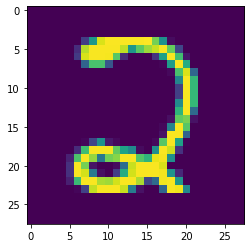

In [ ]:
plt.imshow(test_example_data[0][0].cpu().detach())

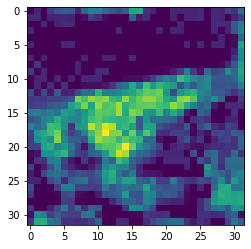

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(test_attack_images[0][0].cpu().detach())

(-0.5, 137.5, 35.5, -0.5)

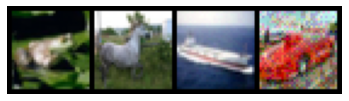

In [ ]:
eps = torch.tensor([0.0001, 0.001, 0.01, 0.1])
images_to_show = test_example_data[:4]
test_attack_images_to_show = images_to_show.cpu() + eps.reshape(-1, 1, 1, 1)*test_example_data.grad.cpu().sign()[:4]
test_attack_images_to_show = torch.clamp(test_attack_images_to_show, 0, 1)
import torchvision

grid_img = torchvision.utils.make_grid(test_attack_images_to_show, nrow=4)
plt.imshow(grid_img.permute(1, 2, 0), cmap='copper')
plt.axis('off')

NameError: ignored

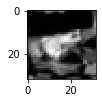

In [ ]:
fig = plt.figure()
for i in range(0, 3):
  plt.subplot(3,2,2*i+1)
  plt.tight_layout()
  plt.imshow(test_example_data[i][0].cpu().detach(), cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(test_example_targets[i]))
  plt.xticks([])
  plt.yticks([])
  plt.subplot(3,2,2*i+2)
  plt.tight_layout()
  plt.imshow(test_attack_images[i][0].cpu().detach(), cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(preds[i]))
  plt.xticks([])
  plt.yticks([])